In [111]:
# -*- coding: utf-8 -*-
"""FHO - Fire Hawk Optimizer Algorithm

Algorithm based on the publication : https://link.springer.com/article/10.1007/s10462-022-10173-w
Original Authors: Mahdi Azizi, Siamak Talatahari & Amir H. Gandomi
Original Python file developped by : Adel Remadi and Hamza Lamsaoub  (Students at CentraleSupélec)
"""

import numpy as np
import matplotlib.pyplot as plt
#from models.multiple_solution.root_multiple import RootAlgo


#class FHO(RootAlgo):
class FHO():
    """ Class for FHO 
    ---------
    self.cost_function: function to optimize
    self.Pop : np.array of Generated Solution Candidates of shape (pop_size,n_dims)
    self.n_dims: dimension of the problem
    self.pop_size : Number of solution candidates (int)
    self.min_bounds : numpy array of dimension (n_dims,) containing the MIN value for each variable
    self.max_bounds : numpy array of dimension (n_dims,) containing the MAX value for each variable
    self.max_generations: Maximum number of generated candidates (int)
    self.best_costs: python list of best costs (list)
    self.costs_iter : python list of cost calculated in each MAIN iteration (list)
    self.minimal_p : minimal point as a numpy array of dimensions (n_dims,)
    """
    
    def __init__(self, min_bounds , max_bounds, pop_size, cost_function , max_generations=200):
        self.max_generations = max_generations
        self.min_bounds      = min_bounds
        self.max_bounds      = max_bounds
        self.cost_function   = cost_function
        self.pop_size        = pop_size
        self.n_dims          = len(min_bounds) #Number of decision variables
        self.Pop             = np.random.uniform(min_bounds,max_bounds,(pop_size,self.n_dims)) #Initial Solution candidates (pop_size,n_dims)
        self.best_costs      = []
        self.costs_iter      = []
        self.minimal_p       = None
        
        
    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i           
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)
            
            #Get territory of fire Hawk i 
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]          
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories
            
                      
    def minimize_FHO(self):
        '''
        Input:
        self
        
        Output:
        GB : global best solution (min f(x))
        self.minimal_p minimal point as a numpy array of dimensions (n_dims,)
        '''
        ## Fire hawk algorithm to minimize the cost function       
        n_dims=self.n_dims
        Pop=self.Pop
        pop_size=self.pop_size
        max_generations = self.max_generations  
        min_bounds=self.min_bounds
        max_bounds=self.max_bounds
        cost_function = self.cost_function
        
        #Evaluate the cost function for all candidate vectors
        cost= np.array([cost_function(Pop[i]) for i in range(pop_size)])
        
        #Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
        
        #Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP=Pop.mean(axis=0)
         
        
        #Select fire hawks
        Fire_Hawks= Pop[:num_Hawks]
        
        #Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]
        
        #get territories
        territories=self.territories(Fire_Hawks,Preys)
        
        #update best
        GB=cost[0]
        Best_Hawk=Pop[0]

        #Counter
        FEs=pop_size

        ## Main Loop
        while FEs < max_generations:
            Pop_Tot=[]
            cost=[]
            #Movement of Fire Hawk for all territories
            for i in territories:
                PR=territories[i].copy()
                FHl=Fire_Hawks[i].copy()
                SPl=PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a,b=np.random.uniform(0,1,size=2)
                FHnear  =Fire_Hawks[np.random.randint(num_Hawks)]                 
                FHl_new =FHl+(a*GB-b*FHnear)
                FHl_new = np.maximum(FHl_new,min_bounds)
                FHl_new = np.minimum(FHl_new,max_bounds)
                Pop_Tot.append(list(FHl_new))
                
                #Movement of the preys following Fire Hawks movement
                for q in range(len(PR)): 
                    a,b=np.random.uniform(0,1,size=2)
                    PRq_new1=PR[q].copy()+((a*FHl-b*SPl))
                    PRq_new1= np.maximum(PRq_new1,min_bounds)
                    PRq_new1 = np.minimum(PRq_new1,max_bounds)
                    Pop_Tot.append(list(PRq_new1))
                    
                    #Movement of the preys outside of territory
                    a,b      =np.random.uniform(0,1,size=2)
                    FHAlter  =Fire_Hawks[np.random.randint(num_Hawks)] 
                    PRq_new2 =PR[q].copy()+((a*FHAlter-b*SP));
                    PRq_new2 = np.maximum(PRq_new2,min_bounds)
                    #The following line for PRq_new2 differs from original algorithm in matlab code (max instead of min):
                    # Effects observed through our testing:
                    # 1/ It converges faster and the costs of the subsequent iterations will tend to decrease (less chaotic behavior than with np.minimun)
                    # 2/ In higher dimensions, it converge to the right solution! (while with np.minimum it does not)
                    PRq_new2 = np.maximum(PRq_new2,max_bounds)
                    Pop_Tot.append(list(PRq_new2))
                             
            #Get cost
            Pop_Tot=np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs = FEs+1
     
            #Create a new population of Hawks and Preys
            order_idx=np.argsort(cost)
            cost.sort()
            Pop_Tot=np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
            Best_Pop=Pop_Tot[0]
            SP=Pop_Tot.mean(axis=0)
            Fire_Hawks=Pop_Tot[:num_Hawks]
            Preys=Pop_Tot[num_Hawks:]          
               
            #Get new territories
            territories=self.territories(Fire_Hawks,Preys)
           
            # Update Global Best cost (if relevant) 
            if cost[0]<GB:
                Best_Position=Best_Pop
                GB=cost[0]
                self.best_costs.append(GB)
                self.minimal_p=Fire_Hawks[0]
            else:
                self.best_costs.append(GB)
           
            #Track the iteration calculated cost
            self.costs_iter.append(cost[0])

        #Return Global Best and argmin
        return (GB,self.minimal_p)
            
    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

<h1>1. Sphere</h1>

Below are plots of the Sphere function in 2-Dimensions.

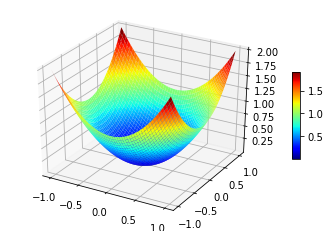

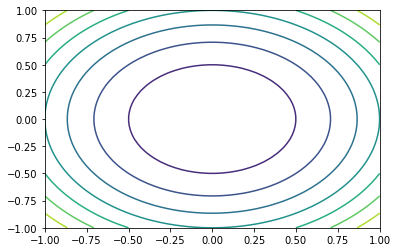

In [66]:
def f(x1,x2):
  a= x1**2+x2**2
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>1.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

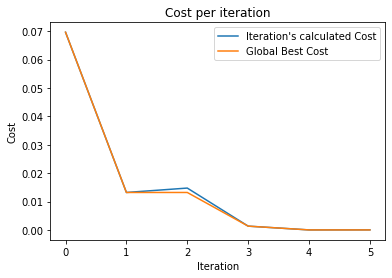

(2.2448855060929707e-05, array([0.0017795 , 0.00439115]))

In [112]:
fonction=lambda x : np.linalg.norm(x)**2

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>1.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 25-Dimensions. We ran it on a range [-100,100] for each axis.

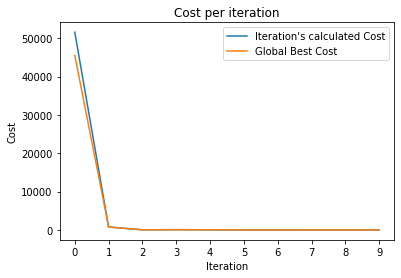

(0.00486422064732861,
 array([0.0135457 , 0.01535917, 0.01424634, 0.01357119, 0.01315392,
        0.01156022, 0.01309077, 0.0160179 , 0.01329709, 0.01341044,
        0.01398503, 0.00974673, 0.01493425, 0.01292845, 0.01576386,
        0.01401354, 0.01555987, 0.01406498, 0.01327362, 0.01421214,
        0.01378969, 0.01573127, 0.01377817, 0.0146077 , 0.01348493]))

In [113]:
fonction=lambda x : np.linalg.norm(x)**2

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>2. Exponential</h1>

Below are plots of the Exponential function in 2-Dimensions.

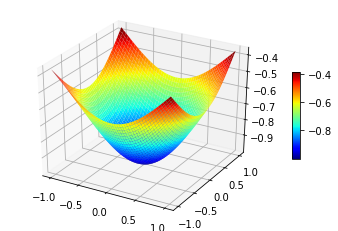

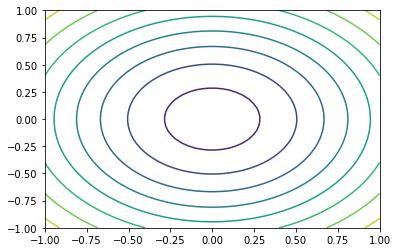

In [69]:
def f(x1,x2):
  a= -np.exp(-0.5*(x1*x1 + x2*x2))
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>2.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 2-Dimensions.

As seen in above plot, the minimum is f(x) = -1 and it is obtained for (x,y)=(0,0).

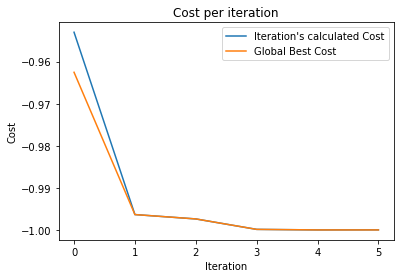

(-0.9999786925505818, array([ 0.00439512, -0.00482683]))

In [114]:
exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, pop_size=200, cost_function = exponential, max_generations=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>2.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 25-Dimensions. We ran it on a range [-30,30] for each axis.

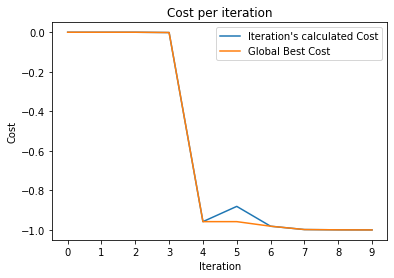

(-0.9999744384121139,
 array([0.00139912, 0.0014846 , 0.00134385, 0.00135149, 0.00150396,
        0.00151001, 0.00133746, 0.00125931, 0.00143637, 0.00155262,
        0.00142429, 0.00131297, 0.00138128, 0.00160532, 0.00154338,
        0.00156082, 0.00127457, 0.00153698, 0.00149069, 0.001503  ,
        0.00144381, 0.00119266, 0.00166874, 0.0012977 , 0.00119994]))

In [115]:
exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, pop_size=200, cost_function = exponential, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>3. Ackley</h1>

Below are plots of the Ackley function in 2-Dimensions.

The Ackley function is non-convex, which could be a challenge for some algorithms.

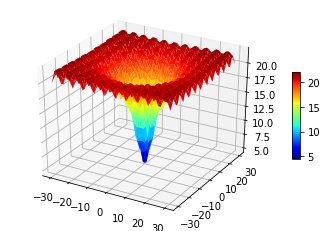

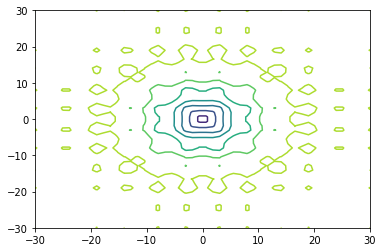

In [74]:
def f(x,y):
  return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))-np.exp(0.5 * (np.cos(2 * np.pi * x)+np.cos(2 * np.pi * y))) + np.e + 20
 

x1= np.linspace(-30,30)
x2= np.linspace(-30,30)
x, y = np.meshgrid(x1, x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>3.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the ackley in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

The Ackley function has many local minimas but the algorithm do not get stuck.

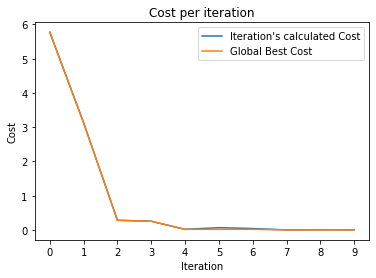

(0.002233732804572952, array([0.00030375, 0.00072272]))

In [116]:
def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=[-30,-30]
maxD=[30,30]

opti=FHO(minD , maxD, pop_size=200, cost_function =  ackley, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>3.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Ackley in 25-Dimensions. We ran it on a range [-30,30] for each axis.

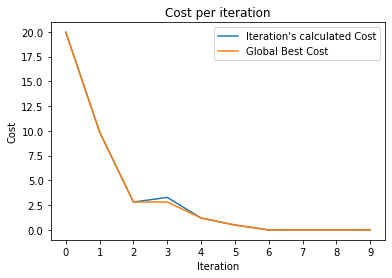

(0.008778760119163564,
 array([ 4.59676161e-03, -1.26931832e-03,  3.05355817e-03,  1.43946017e-03,
         3.62340287e-04, -2.74927427e-06, -2.68689503e-03, -8.47941547e-04,
         9.88497600e-04,  2.88105535e-04,  3.41577163e-04,  3.49191843e-04,
        -2.24663483e-04,  1.22600805e-03,  3.92967097e-03,  5.31436349e-03,
         1.97934845e-03, -1.06956053e-03,  5.31844196e-04,  1.11188597e-03,
        -9.69999320e-04,  3.80470595e-04,  3.71122519e-03,  1.91510620e-03,
         5.90595906e-05]))

In [117]:
def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, pop_size=200, cost_function = ackley, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>4. Becker-lago</h1>

Below are plots of the Becker-lago function in 2-Dimensions.


$$f(X)=(|x1|−5)^2+(|x2|−5)^2$$

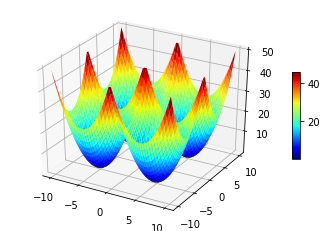

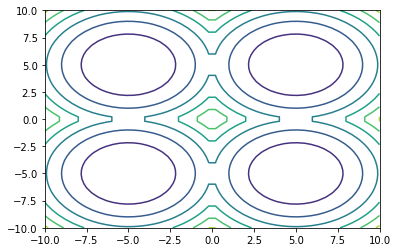

In [79]:
def f(x,y):
  return (np.abs(x)-5)**2+(np.abs(y)-5)**2
 
x1= np.linspace(-10,10)
x2= np.linspace(-10,10)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>4.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 2-Dimensions.

As seen in above plot, the Becker-Lago is non convex, non differentiable and it has 4 minimum solutions such that $f(x) = 0$ for: 
$$$$

$$(x,y) \in \{(-5,-5),(-5,5),(5,-5),(5,5)\}$$

The below code converge towards any of the minimums.

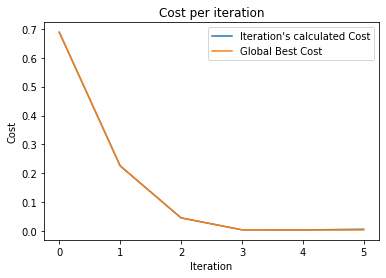

(0.00414394706484765, array([5.015088  , 4.93741966]))

In [118]:
def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=[-30,-30]
maxD=[30,30]

opti=FHO(minD , maxD, pop_size=200, cost_function = becker_lago, max_generations=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h2>4.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 25-Dimensions. We ran it on a range [-30,30] for each axis.

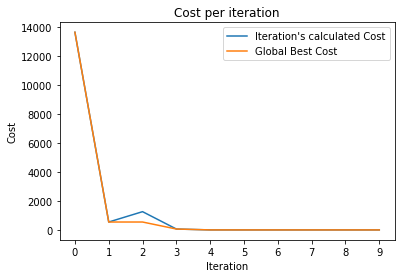

(0.001093935283423354,
 array([5.00887797, 5.00078156, 4.99448751, 4.99787329, 4.99706958,
        5.00776559, 5.00555935, 4.99774136, 4.99377666, 4.99494524,
        5.00338396, 5.01259628, 5.00642738, 4.98519097, 4.99809215,
        5.00626896, 5.00148458, 5.0107768 , 5.00236131, 5.00854392,
        4.99116325, 4.99702924, 5.00389264, 4.9992726 , 4.99389862]))

In [119]:
def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, pop_size=200, cost_function = becker_lago, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>5. Bird function</h2>



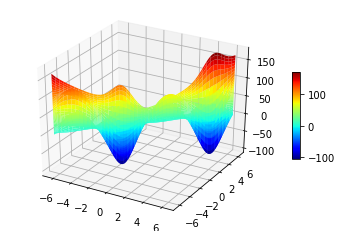

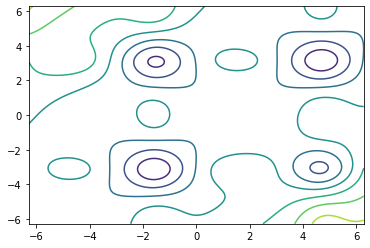

In [83]:
def f(x,y):
 return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

x= np.linspace(-2*np.pi,2*np.pi,1000)
y= np.linspace(-2*np.pi,2*np.pi,1000)
X,Y= np.meshgrid(x,y)
results= f(X,Y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()
plt.contour(x,y,results)
plt.show()

<h2>4.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Bird in 2-Dimensions.

The function has two global minima in [-2$\pi$,2$\pi$] at f(x)= −106.764537 located at :
(4.70104 ,3.15294) and  (−1.58214 ,−3.13024)

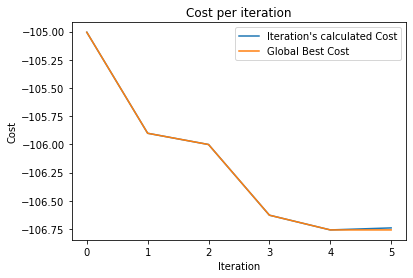

(-106.75889596587304, array([4.68063961, 3.1467994 ]))

In [122]:
def bird(X):
  x,y = X
  return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

minD=[-2*np.pi,-2*np.pi]
maxD=[2*np.pi,2*np.pi]

opti=FHO(minD , maxD, pop_size=200, cost_function =  bird, max_generations=20000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b